# Visualizing academic literature from PubMed on extreme heat & humans for the last 10 years

## Section 1 - Download academic literature on heat realted ilnesses

[PubMed](https://pubmed.ncbi.nlm.nih.gov/) is a free online database and search engine widely used for accessing and searching scientific and medical literature. It is maintained by the National Center for Biotechnology Information (NCBI), which is a part of the United States National Library of Medicine (NLM) at the National Institutes of Health (NIH)

The PubMed API (Application Programming Interface) is a set of web services provided by NCBI that allows developers to programmatically access and retrieve data from the PubMed database.

The [BioPython](https://biopython.org/) package provides utilities to search and download data from the PubMed database. Sign up for a NIH account and generate API key here.

In [1]:
import pandas as pd
import json

!pip install biopython
from Bio import Entrez

You should consider upgrading via the '/Users/shrutimukhtyar/Projects/datathon/scispacy/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
# Set your API key
Entrez.email = ""  # Replace with your email
Entrez.api_key = "" # Replace with your API key

In [ ]:
# Set query string
search_term = '"extreme heat"[All Fields]) AND ((y_10[Filter]) AND (humans[Filter])'

In [ ]:
# Retrieve the results
handle = Entrez.esearch(db="pubmed", term=search_term, retmax=1500)  # Adjust retmax as needed
record = Entrez.read(handle)
handle.close()
print(f"{record['Count']} results found")

In [ ]:
# Make a list of PubMed ids for all results
pmids = record['IdList']

# Create an empty DataFrame to store results
df = pd.DataFrame(columns=["PMID", "Title", "Abstract", "Authors", "Author Affiliations", "Author Keywords", "Publication Title", "Publication Year", "Mesh_Terms"])

In [ ]:
# Retrieve title, abstract & other metadata for each article
for pmid in pmids:
    try:
        handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
        record = Entrez.read(handle)
        handle.close()

        #print(json.dumps(record, indent=2))

        citation = record['PubmedArticle'][0]['MedlineCitation']
        keyword_list = citation.get('KeywordList', [])
        mesh_heading_list = citation.get('MeshHeadingList', [])

        article = citation['Article']
        title = article['ArticleTitle']
        author_list = article['AuthorList']

        # Check if the abstract is available
        if 'Abstract' in article:
            abstract = article['Abstract']['AbstractText']
            abstract = ' '.join(abstract)
        else:
            abstract = " "

        # Extract author names & author affiliations
        affiliations = []
        authors = []
        for author in author_list:
            if 'LastName' in author and 'Initials' in author:
                full_name = f"{author['LastName']} {author['Initials']}"
                authors.append(full_name)
            if 'AffiliationInfo' in author:
                affiliation_info = author['AffiliationInfo']
                if len(affiliation_info):
                  affiliation_name_first = affiliation_info[0]
                  affiliations.append(affiliation_name_first.get('Affiliation', "Not available"))


        # Extract author keywords
        keywords = []
        if len(keyword_list):
          for keyword in keyword_list[0]:
            keywords.append(keyword)

        # Extract Mesh terms
        mesh_terms = []
        if len(mesh_heading_list):
          for mesh_heading in mesh_heading_list:
            if 'DescriptorName' in mesh_heading:
              term = f"{mesh_heading['DescriptorName']}"
              mesh_terms.append(term)

        # Extract journal information and publication date
        journal_info = article['Journal']
        journal = journal_info.get('Title', 'Journal not available')
        issue = journal_info.get('JournalIssue', 'Journal issue not available')
        pub_date = issue.get('PubDate', 'PubDate not available')
        pub_year = pub_date.get('Year', 'Year not available')

        # Create a new DataFrame with the current data
        row = pd.DataFrame({
            "PMID": [pmid],
            "Title": [title],
            "Abstract": [abstract],
            "Authors": ['; '.join(authors)],
            "Author Affiliations": ['; '.join(affiliations)],
            "Author Keywords": [';'.join(keywords)],
            "Publication Title": [journal],
            "Publication Year": [pub_year],
            "Mesh_Terms": [';'.join(mesh_terms)],
        })

        # Concatenate the new DataFrame with the main DataFrame
        df = pd.concat([df, row], ignore_index=True)
    except Exception as e:
        print(f"Error retrieving data for PMID {pmid}: {str(e)}")

In [ ]:
# Export dataframe to csv
csv_file_name = 'pubmed_extreme-heat_data.csv'
df.to_csv(csv_file_name)

## Section 2 - Topic Modeling

Topic modeling is an unsupervised machine learning technique that’s capable of scanning a set of documents, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents.

The following are key factors to obtaining good segregation topics:
- The quality of text processing.
- The variety of topics the text talks about.
- The choice of topic modeling algorithm.
- The number of topics fed to the algorithm.
- The algorithms tuning parameters.

References:
- [Topic Modelling in Python with spaCy and Gensim](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)
- [Clinical Natural Language Processing in Python](https://www.andrewvillazon.com/clinical-natural-language-processing-python/)

In [126]:
import re
import warnings
import numpy as np

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import scispacy
import spacy
from scispacy.abbreviation import AbbreviationDetector

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Collecting the data

In [164]:
# Read data file
df = pd.read_csv('pubmed_extreme-heat_data.csv')

# Drop column if there is a column label Unnamed
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]

# Combine title & abstract for analysis
df['text'] = df['Title'] + ' ' + df['Abstract']

In [11]:
# Remove html tags
clean = re.compile('<.*?>')

def remove_html_tags(text):
    """Remove html tags from a string"""
    return re.sub(clean, '', text)

df['text'] = df['text'].apply(lambda x: remove_html_tags(x))

### Preprocess the data 
Clean and prepare the text data using spaCy. [scispaCy](https://allenai.github.io/scispacy/) is a Python package containing spaCy models for processing biomedical, scientific or clinical text.

The text processing pipeline uses an Entity Detection model called `en_core_sci_sm`. This model is one of the several models available with scispaCy which are pre trained on biomedical/scientific data.

In [74]:
# Create spacy model:
nlp = spacy.load("en_core_sci_sm")

# Add the Merge noun chunks into a single token to the spacy pipeline.
nlp.add_pipe("merge_noun_chunks")

<function spacy.pipeline.functions.merge_noun_chunks(doc: spacy.tokens.doc.Doc) -> spacy.tokens.doc.Doc>

In [129]:
# Call the scispaCy pipeline on one of the records nd inspect the token attributes.
doc = nlp(df.loc[12, 'text'])
fmt_str = "{:<15}| {:<6}| {:<7}| {:<8}"
print(fmt_str.format("token", "pos", "label", "parent"))

for token in doc:
    print(fmt_str.format(token.text, token.pos_, token.ent_type_, token.lemma_))

token          | pos   | label  | parent  
Seasonality    | NOUN  | ENTITY | seasonality
of             | ADP   |        | of      
acute          | ADJ   | ENTITY | acute   
kidney         | NOUN  | ENTITY | kidney  
injury         | NOUN  | ENTITY | injury  
phenotypes     | NOUN  | ENTITY | phenotype
in             | ADP   |        | in      
England        | PROPN | ENTITY | England 
:              | PUNCT |        | :       
an             | DET   |        | an      
unsupervised   | ADJ   | ENTITY | unsupervised
machine        | NOUN  | ENTITY | machine 
learning       | NOUN  | ENTITY | learning
classification | NOUN  | ENTITY | classification
study          | NOUN  |        | study   
of             | ADP   |        | of      
electronic     | ADJ   | ENTITY | electronic
health         | NOUN  | ENTITY | health  
records        | NOUN  | ENTITY | record  
.              | PUNCT |        | .       
Acute Kidney Injury| PROPN | ENTITY | acute Kidney Injury
(AKI           | NOUN  

In [130]:
# Run the scispaCy pipeline on all documents
# Create a list of tokens for each document
# Keep only words labeled ENTITY and filter out stop words
keep = ['ENTITY']
tokens = []
for text in nlp.pipe(df['text']):
    proj_tok = [token.lemma_.lower() for token in text if token.ent_type_ in keep and not token.is_stop]
    tokens.append(proj_tok)

In [165]:
# Add tokens to dataframe
# Convert the list of tokens to strings
#token_strings = [";".join(sublist) for sublist in tokens]
df['tokens'] = tokens

In [137]:
# Apply the Dictionary Object from Gensim, which maps each word to their unique ID:\
# Filter out tokens that that appear in less than 5 documents
dictionary = Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=5)

In [138]:
# Construct the corpus
# doc2bow counts the number of occurrences of each distinct word,
# converts the word to its integer word id
# and returns the result as a sparse vector
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

### Model building
Train the unsupervised machine learning model on the data. Insert the corpus into the topic modelling algorithm to find the distribution of words in each topic and the distribution of topics in each document

In [139]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=15, workers = 4, passes=10)

/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning

To evaluate the model, calculate a coherence score. The score measures the degree of semantic similarity between high scoring words in each topic.

/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning

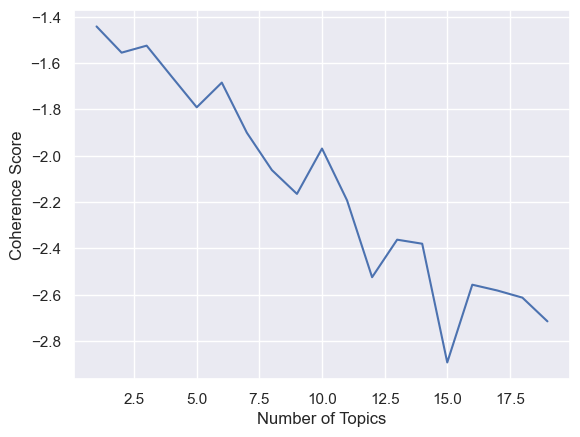

In [140]:
# Calculate the coherence score using C_umass
topics = []
score = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(1,20,1):
       lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
       cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
       topics.append(i)
       score.append(cm.get_coherence())
    _=plt.plot(topics, score)
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Coherence Score')
plt.show()

/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning

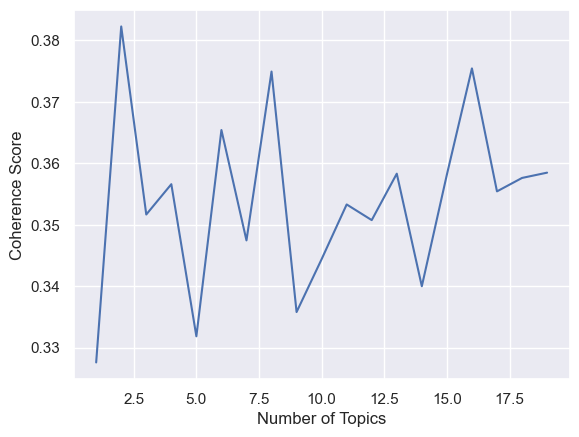

In [141]:
# Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [142]:
# Choose numper of topics depending on max coherence using the C_umass or C_v algorithm
# Although there is not right answer
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=15, workers = 4, passes=100)

/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shrutimukhtyar/Projects/datathon/scispacy/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning

### Visualize topics

Visualize topics using [pyLDAvis](https://pypi.org/project/pyLDAvis/). pyLDAvis is a python libarary for interactive topic model visualization.

In [143]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

The above chart represents 15 topics as circles. They have been drawn using a dimensionality reduction technique called PCA. The goal is to have a distance in order to avoid overlapping and make each circle unique. Hovering over a circle shows word frequency (blue) and estimated term frequency within the selected topic (red) for different words. Topics closer to each other are more related. 

In [150]:
# Save vis as html
pyLDAvis.save_html(lda_display, 'lda-model.html')

In [151]:
# Save vis as json
pyLDAvis.save_json(lda_display, 'lda-model.json')

In [166]:
# Add Topics to dataframe
df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df['text']))]

In [167]:
df.topic.value_counts()

topic
0     190
1     150
3     103
2      85
5      65
4      50
7      31
8      24
6      23
10     20
9      19
12     13
11     12
13      6
14      5
Name: count, dtype: int64

In [170]:
# Save dataframe with new tokens & topic columns to json
df.to_json('pubmed_extreme-heat_data_topics.json', orient='records')